# Epidemic simulation over a real-world graph

In this projet we will mathematically model the spreading of an infectious disease among a group of people.
The model used to run the simulation is the SIR model https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model). In this case, the epidemic is modeled as a process over a graph that represents the population of individuals: nodes are people whose social interactions are represented through edges. 

We will then be asked to choose N sentinel-nodes. In other words, we want to choose a (possibly) small number of individuals to monitor, so that if an epidemic is spreading over the graph, we will be alarmed at the very initial stage of it.
We will do so both with complete and partial information about the social graphs itself.

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter
import operator
import random

%matplotlib inline

## Part 1

### 1.1 Degree distribution

In this analysis I used the graph *CA-HepTh* from the Stanford SNAP repository, a graph that represents the scientific collaborations between authors papers submitted to High Energy Physics - Theory category.

In [4]:
# Import the txt file and build the (undirected) graph
G0 = nx.Graph()
f = open("CA-HepTh.txt")
for line in f:
    s = line.strip().split()
    G0.add_edge(s[0],s[1])
f.close()
#check if the resulting graph is connected
nx.is_connected(G0)

False

Since G0 is not connected, select its largest connected component

In [7]:
# List of the connected compononents oredered by their nodes number, in decreasing order
Gcc = sorted(nx.connected_component_subgraphs(G0), key = len, reverse=True)
G = Gcc[0]

Computation of the degree distribution:

In [20]:
# dictionary node: degree
degrees = {node:val for (node, val) in G.degree()} 
# the set of all the values of the degrees
values = sorted(set(degrees.values()))
# list number of nodes with degree v
hist = [sum(map((v).__eq__, degrees.values())) for v in values]

Loglog plot of the degree distribution

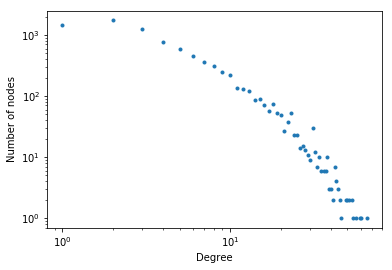

In [21]:
plt.loglog(values,hist,'.') 
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.show()

### 1.2 Epidemic simulation

Set up a simulation of an SIR epidemic model on the graph. Choose values of the model parameters \beta and \mu that allow the epidemic to take off with high probability, reaching most of the graph. Plot the epidemic curve.

In [23]:
def simulateSIR(G, mu, beta, seed):
    
    # set up initial state of the system

    # list of infected nodes
    infected_nodes = [seed]

    # we need to store the disease status of each node
    # S=0, I=1, R=-1
    G.disease_status = dict((n,0) for n in G.nodes())
    
    G.disease_status[seed] = 1

    # used to store the history of the system
    I_net = []
    
    # loop until there are infectious nodes
    while len(infected_nodes) > 0:
        # store state:
        # each item is a tuple of the form (<number of infected nodes>, <node dictionary>),
        # where <node dictionary> has node IDs as keys and node disease status as values.
        I_net.append( (len(infected_nodes), G.disease_status.copy()) )

        # TRANSMISSION: loop over infectious nodes
        for i in infected_nodes:
            # loop over the neighbors of infectious nodes
            for j in G.neighbors(i):
                if G.disease_status[j] == 0:
                    # here j is a susceptible neighbor of infectious node i
                    if np.random.random() < beta:
                        G.disease_status[j] = 1 # node j has now been infected
        
        # RECOVERY
        for k in infected_nodes:             
            if np.random.random() < mu:
                G.disease_status[k] = -1

        # update list of infectious nodes
        infected_nodes = [n for n in G.nodes() if G.disease_status[n] == 1]
        
    I_net.append( (len(infected_nodes), G.disease_status.copy()) )
    return(I_net)

In [24]:
# Parameters
B=0.08; M=0.02

In [32]:
# Nodes ordered by degree in increasing order
#nodes_bydegree = map(itemgetter(0), sorted(G.degree_iter(), key=itemgetter(1)))
nodes_bydegree = list(map(itemgetter(0), sorted(degrees.items(), key=operator.itemgetter(1))))
# Choose the seed node as the node with max degree
seed = nodes_bydegree[-1]

# Run a simulation of the epidemic
I_net = simulateSIR(G,beta=B,mu=M,seed=seed)

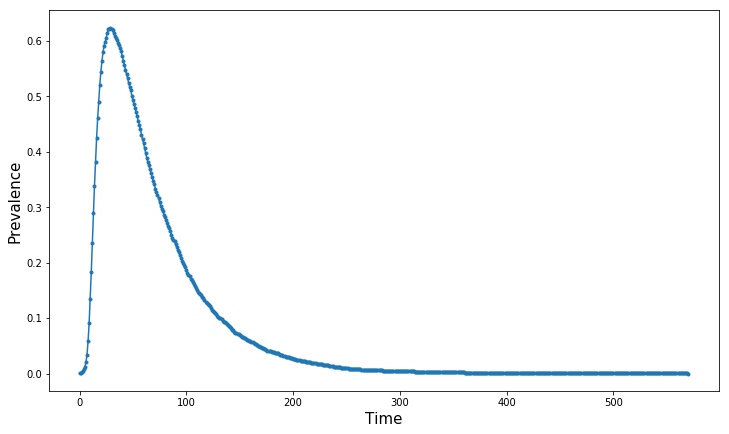

In [34]:
plt.figure(figsize=(12,7))
plt.xlabel('Time', fontsize=15)
plt.ylabel('Prevalence', fontsize=15)
plt.plot(range(0,len(I_net)), [float(n)/len(G.nodes()) for n, state in I_net], '.-' )

In [37]:
recovered = len([n for n in G.disease_status if G.disease_status[n] == -1])
final_t = len(I_net)

print ("Total number of nodes", G.number_of_nodes())
print ("The total number of recovered nodes is", recovered)
print ("The final attack rate is", float(recovered)/len(G.nodes()))
print ("The epidemic is over at time", final_t)

Total number of nodes 8638
The total number of recovered nodes is 8053
The final attack rate is 0.9322759898124566
The epidemic is over at time 571


Hence with this choice of the parameters $\beta$ and $\mu$ and of the seed, the epidemic spread on over the $93\%$ of the graph.

## Part 2

### 2.1 Modify the simulation function

Modify the simulation function of the SIR model, introducing a list of N sentinels.
The function takes in input:
- the graph G
- $\mu$ and $\beta$
- the list of sentinels
- the seed

For every sentinel in the list, I store its arrival time (i.e. the time at which the sentinel is infected) into the list *arrival_times*.
Then I compute the mean arrival time on all the sentinels that have been infected. In this analysis I am not considering the fraction of not-infected sentinel, since the epidemic reaches the $93\%$ of the nodes.

The output is the mean arrival time of the epidemic at the sentinels.

In [38]:
def SIR_arrival_time(G, mu, beta, sentinels,seed):
   
    # list of infected nodes
    infected_nodes = [ seed ]

    # we need to store the disease status of each node
    # S=0, I=1, R=-1
    G.disease_status = dict((n,0) for n in G.nodes())
    G.disease_status[seed] = 1
    
    # counter, the simulation begins at time=1
    time = 0
    
    # in this list I will store the arrival time at each sentinel
    arrival_times=[]    
    
    # loop until there are infectious nodes
    while len(infected_nodes) > 0:
        
        time = time +1
        # store state:
        # each item is a tuple of the form (<number of infected nodes>, <node dictionary>),
        # where <node dictionary> has node IDs as keys and node disease status as values.
        
        
        # TRANSMISSION: loop over infectious nodes
        for i in infected_nodes:
            # loop over the neighbors of infectious nodes
            for j in G.neighbors(i):
                if G.disease_status[j] == 0:
                    # here j is a susceptible neighbor of infectious node i
                    p = np.random.random()
                    if p < beta:
                        G.disease_status[j] = 1 # node j has now been infected
                        
                        # if the infected node is a sentinel, append the current time 
                        # to the final list
                        if j in sentinels:
                            arrival_times.append(time)
        
        # RECOVERY
        for k in infected_nodes:            
            p = np.random.random()
            if p < mu:
                G.disease_status[k] = -1

        # update list of infectious nodes
        infected_nodes = [n for n in G.nodes() if G.disease_status[n] == 1]
    
    # return the mean arrival time
    return(np.mean(arrival_times))

In [39]:
# the number of sentinels
# is about the 1% of the total number of nodes
N = 100  

Now choose $N=100$ sentinel nodes and simulate the distribution of the arrival time of the epidemic at each sentinel.

In [40]:
# Choose N random nodes
random_sentinels = random.sample(G.nodes(),N)
# Run 500 simulation of the epidemic
arr_time_distr = [SIR_arrival_time(G=G, mu=M, beta=B,sentinels=random_sentinels,seed=seed) for i in range(500)]

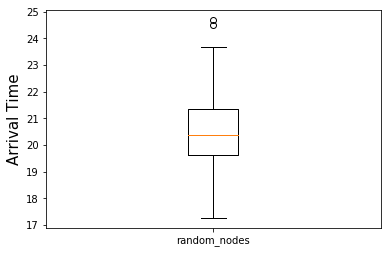

In [41]:
plt.ylabel('Arrival Time', fontsize=15)
p=plt.boxplot(arr_time_distr,labels=['random_nodes'])

### 2.2  Simulations with random sentinels

Consider many random choices for the N sentinel nodes, as well as many epidemics (as already done above), and recompute the above distribution of arrival times (so that this times, it also takes into account the randomness due to the random selection of sentinel nodes).

In [18]:
# For every iteration, sample N random nodes from G.nodes() and use them as sentinel
# Run 500 simulations
arrival_time_distribution_random = [ SIR_arrival_time(G,beta=B,mu=M,sentinels=random.sample(G.nodes(),N),seed=seed) for i in range(500)]

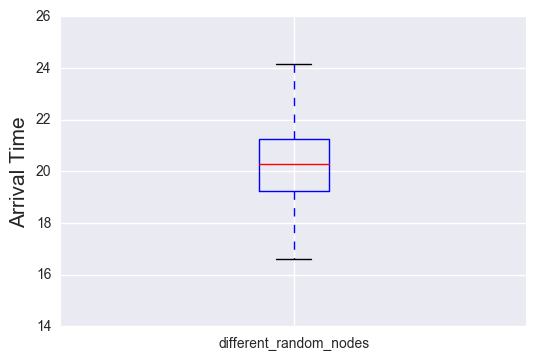

In [19]:
plt.ylabel('Arrival Time', fontsize=15)
p=plt.boxplot(arrival_time_distribution_random, labels=['different_random_nodes'])

### 2.3 Centrality Metrics

Compute a few centrality metrics for all the nodes of the network. For each of these metrics, compute a global ranking of nodes and choose as sentinels the top-N and bottom-N nodes of the ranking. Re-run the simulations above and see how the resulting distribution of arrival times is affected. Comapre the results in a boxplot.

#### Degree Centrality

In [42]:
# the N nodes with lowest degree
sentinel_low_deg = nodes_bydegree[0:N]
arrival_time_distribution_low_deg = [SIR_arrival_time(G,beta=B,mu=M,seed=seed,
                                            sentinels=sentinel_low_deg) for i in range(100)]

# the N nodes with highest degree, excluding the seed
sentinel_top_degree = nodes_bydegree[-N-2:-2]
arrival_time_distribution_top_degree = [SIR_arrival_time(G,beta=B,mu=M,seed=seed,sentinels=sentinel_top_degree ) for i in range(500)]

#### Closeness Centrality

In [21]:
# dictionary node: closeness centrality
closn = nx.closeness_centrality(G)

# Select the N nodes with largest closeness centrality
sentinel_top_closeness = map(itemgetter(0),sorted(closn.items(), key=operator.itemgetter(1)))[-N-1:-1]
arrival_time_distribution_top_closeness = [SIR_arrival_time(G,beta=B,mu=M,seed=seed,sentinels=sentinel_top_closeness ) for i in range(500)]

#### Betweenness Centrality

In [27]:
# dictionary node: betweenness centrality
betw = nx.betweenness_centrality(G)

# Select as sentinels the N nodes with highest betweenness centrality
sentinel_top_betweennes = map(itemgetter(0),sorted(betw.items(), key=operator.itemgetter(1)))[-N-1:-1]
arrival_time_distribution_top_betweennes = [SIR_arrival_time(G,beta=B,mu=M,seed=seed, sentinels=sentinel_top_betweennes) for i in range(500)]

#### PageRank Centrality

In [31]:
# dictionary node: pagerank
pagerank = nx.pagerank(G)

# Select the sentinels as the N nodes with highest pagerank
sentinel_top_pagerank = map(itemgetter(0),sorted(pagerank.items(), key=operator.itemgetter(1)))[-N-1:-1]
arrival_time_distribution_top_pagerank = [SIR_arrival_time(G,beta=B,mu=M,seed=seed,sentinels=sentinel_top_pagerank) for i in range(500)]


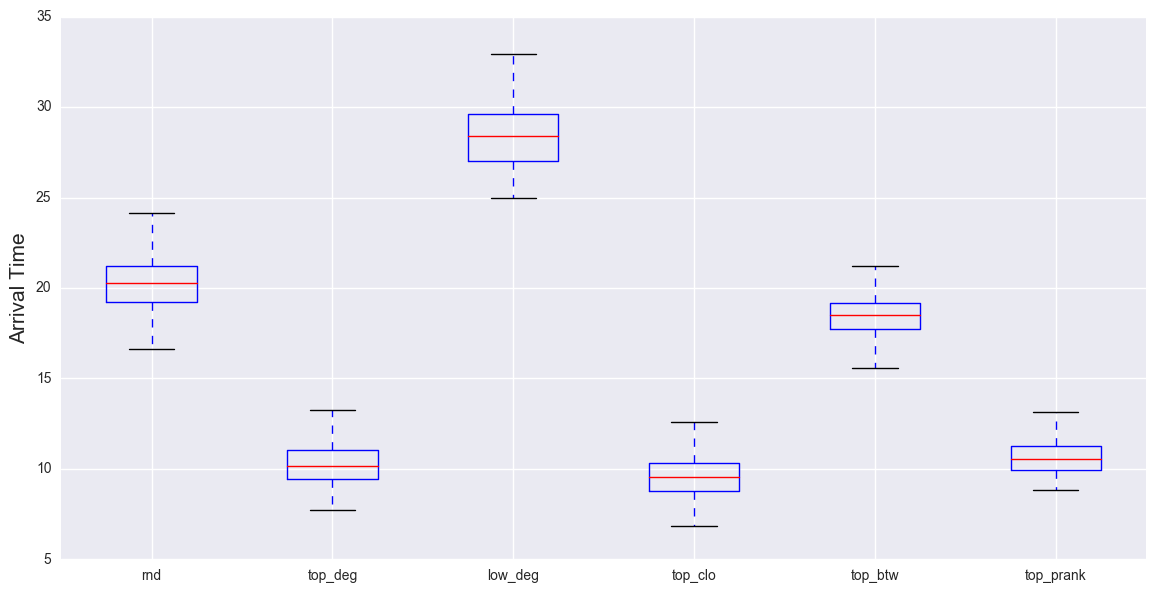

In [32]:
plt.figure(figsize=(14,7))
plt.ylabel('Arrival Time', fontsize=15)
data = [arrival_time_distribution_random,
        arrival_time_distribution_top_degree, arrival_time_distribution_low_deg,
        arrival_time_distribution_top_closeness,
        arrival_time_distribution_top_betweennes,
        arrival_time_distribution_top_pagerank]
labels = ['rnd','top_deg','low_deg','top_clo','top_btw','top_prank']
p=plt.boxplot(data,labels=labels)

From this boxplot we can see that choosing the $N$ nodes with highest centrlity, gives an improvement with respect to the random choice of the sentinel.

The three centrlity metrics that give better results are the Closeness, Degree and PageRank.

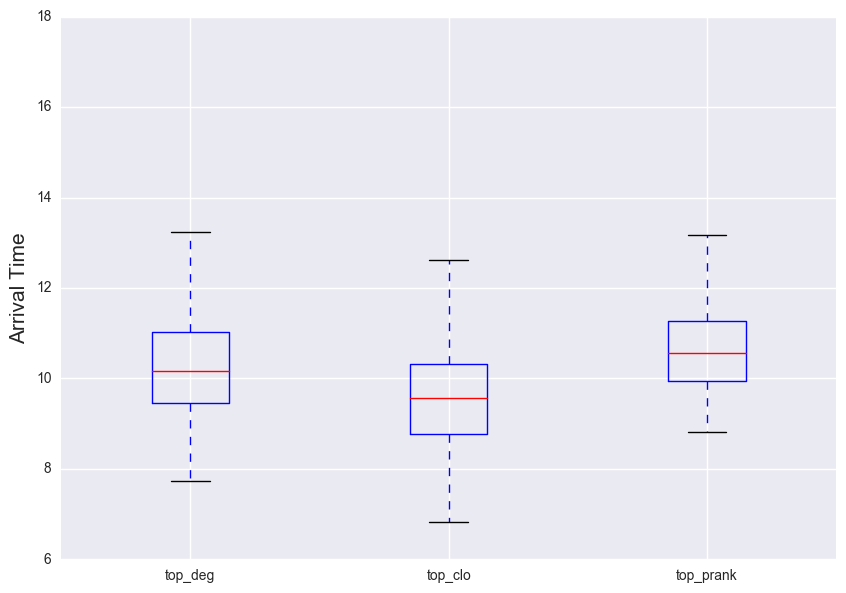

In [33]:
plt.figure(figsize=(10,7))
plt.ylabel('Arrival Time', fontsize=15)
data = [arrival_time_distribution_top_degree, 
        arrival_time_distribution_top_closeness,
        arrival_time_distribution_top_pagerank]
labels = ['top_deg','top_clo','top_prank']
p=plt.boxplot(data,labels=labels)

Since a node can infect only its neighbors, the probability that a given infected node *a* will infect a suscetible node *b* is inversely proportional to their distance. Choosing as sentinels the $N$ nodes with highest Closeness Centrality is equivalent to choose the $N$ nodes that have a smaller average distance from all the other nodes in the graph. Hence they will also be the nodes that get infected earlier.

Besides a node is infected only by its neighbors. Hence the probability that a certain susceptible node *a* will be infected is directly proportional to its degree. This is why the Degree Centrality metrics performs very well too. The PageRank Centrality instead takes into account also the degree of the neighbors of the node *a*.

## Part 3

Let us select N nodes at random as sentinels. Imagine that we do not have global information about the graph, and that we have information about the graph neighborhoods of the chosen nodes. That is, we know the identity of the randomly chosen nodes, the identify of their neighbors, and the edges among the latter. Starting from the initial random set of N nodes, can we build another set of N nodes that improves (reduced) the average detection time of the epidemic?

### 3.1

I will run 200 simulation of the epidemic, in order to compute the arrival time distribution of the epidemic with three different set of sentinels:
1. the given $N$ random nodes
2. for every random node, choose one of its neighbors at random
3. for every random node, choose its neighbor with maximum degree

In [34]:
# Choose N nodes at random 
random_nodes = random.sample(G.nodes(),N)

# dictionary node: subgraph induced by its neighbors
subgraphs = {node: G.subgraph(G.neighbors(node)) for node in random_nodes}

# Run 200 simulation using the given random nodes, in order to have a measure of the improvement interms of arrival time
arr_time_partial_knowledge_ = [SIR_arrival_time(G,beta=B,mu=M,seed=seed,sentinels=random_nodes ) for i in range(200)]

# For each random node, I pick at random one of its neighbors and I append it in the list of the sentinel nodes
sentinel_rnd = [random.sample(subgraphs[node].nodes() ,1)[0] for node in random_nodes]
# With this choice of the sentinels, run the 200 simulations
arr_time_partial_knowledge_rnd = [SIR_arrival_time(G,beta=B,mu=M,seed=seed,sentinels=sentinel_rnd ) for i in range(200)]

# For each random node, pick its neighbors with max degree
sentinel_max_deg = [sorted(subgraphs[node].degree_iter(), key=itemgetter(1))[-1][0] for node in random_nodes]
# With this choice of the sentinel nodes, run 200 simulations
arr_time_partial_knowledge_max_deg = [SIR_arrival_time(G,beta=B,mu=M,seed=seed,sentinels=sentinel_max_deg) for i in range(200)]

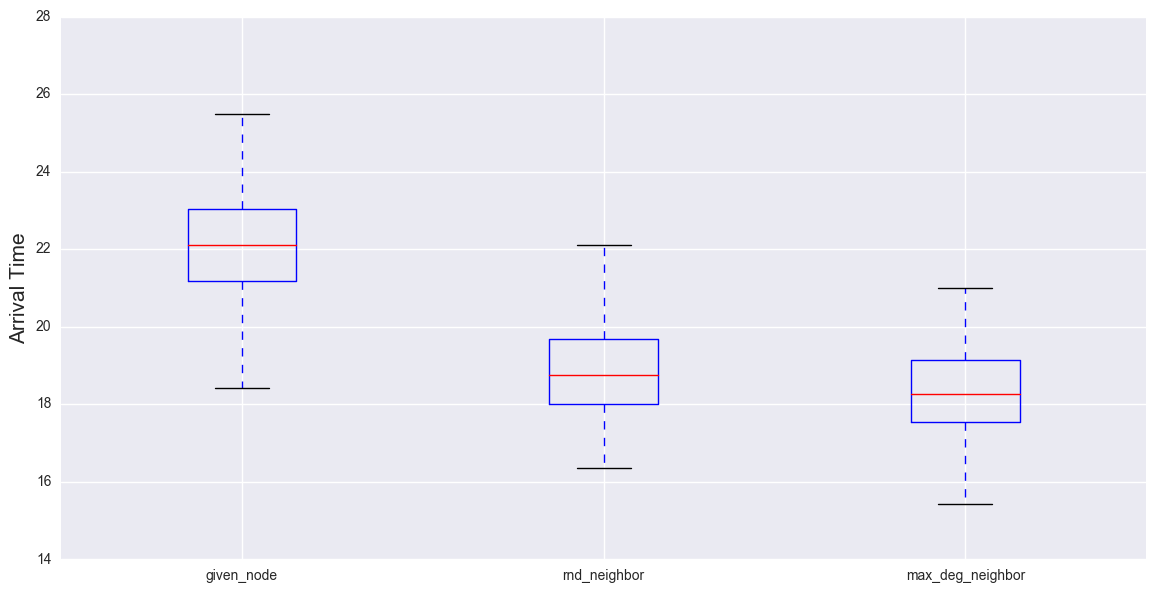

In [35]:
# Plot the results into a boxplot
data = [arr_time_partial_knowledge_,arr_time_partial_knowledge_rnd, arr_time_partial_knowledge_max_deg]
labels = ['given_node','rnd_neighbor','max_deg_neighbor']
plt.figure(figsize=(14,7))
plt.ylabel('Arrival Time', fontsize=15)
p=plt.boxplot(data,labels=labels)

### 3.2

2. The reason why choosing a random neighbor improves result is due to the so-called *friendship paradox*: on average my friends are more popular than I am. This happens because a node is more likely to connected with hubs than with small-degree nodes, simply because hubs have more neighbors than the small nodes. (Barabasi - *Network Science*, cap7).

3. Given a random node *a*, the probability that one of its neighbors $\nu$ has a degree $d_{SG}(\nu)$ in the subgraph induced by *a* and its neighbors, is directly proportional to the degree that $\nu$ has in the original larger graph $G$, namely $d_G(\nu)$. Hence, if for every random node I pick its neighbor $\nu$ with highest $d_{SG}(\nu)$, I can reasonably expect that $\nu$ will also have an higher degree $d_G(\nu)$ with respect to the other neighbors of *a*